In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Load and clean dataset
df = pd.read_csv(r"C:\Users\LENOVO\Desktop\Pro\Accidental_Drug_Related_Deaths_2012-2023 (1).csv", encoding='ISO-8859-1')

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Display dataset info
print("Initial Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

# Handle missing values
print("\nMissing Values Per Column:")
missing = df.isnull().sum()
print(missing[missing > 0])

df['age'].fillna(df['age'].median(), inplace=True)
df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df.dropna(subset=['cause_of_death'], inplace=True)

# Remove duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"\n🧹 Removed {initial_rows - df.shape[0]} duplicate rows.")

# Convert and clean columns
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[(df['age'] >= 10) & (df['age'] <= 100)]
df['sex'] = df['sex'].astype('category')
df['cause_of_death'] = df['cause_of_death'].str.strip().str.lower().replace({'unkown': 'unknown', 'unknwn': 'unknown'})
df['residence_city'] = df['residence_city'].fillna('Unknown').str.strip().str.title()

# Drug column processing
drug_cols = ['heroin', 'fentanyl', 'cocaine', 'alcohol', 'benzodiazepine', 'methadone', 'oxycodone', 'hydrocodone']
present_drugs = [col for col in drug_cols if col in df.columns]
print(f"\nDrug Columns Found: {present_drugs}")
print(f"Drug Columns Missing: {[col for col in drug_cols if col not in df.columns]}")

# Drop rows with all drug data missing
if present_drugs:
    df = df[~df[present_drugs].isnull().all(axis=1)]

# Filter valid date range
df = df[(df['date'] >= '2012-01-01') & (df['date'] <= '2023-12-31')]

# Feature engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()

# Convert drug indicators to 0/1 and compute count
substance_cols = ['heroin', 'cocaine', 'fentanyl', 'ethanol', 'oxycodone', 'benzodiazepine', 'methadone']
df[substance_cols] = df[substance_cols].apply(lambda col: col.map({'Y': 1, 'N': 0, 'Yes': 1, 'No': 0, 'y': 1, 'n': 0}).fillna(0))
df['number_of_substances'] = df[substance_cols].sum(axis=1)

# Final cleanup and save
df.drop_duplicates(inplace=True)
df = df.sort_values(by='date')

file_name = f"Cleaned_Accidental_Drug_Deaths_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(file_name, index=False)
print(f"\nCleaned dataset saved as: {file_name}")

print("\nFinal Dataset Info:")
print(df.info())

print("\nTop 10 Causes of Death:")
print(df['cause_of_death'].value_counts().head(10))

print("\nFinal Column Names:")
print(df.columns.tolist())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           11981 non-null  object 
 1   date_type                      11981 non-null  object 
 2   age                            11979 non-null  float64
 3   sex                            11972 non-null  object 
 4   race                           11924 non-null  object 
 5   ethnicity                      2565 non-null   object 
 6   residence_city                 11385 non-null  object 
 7   residence_county               10721 non-null  object 
 8   residence_state                9993 non-null   object 
 9   injury_city                    11803 non-null  object 
 10  injury_county                  8647 non-null   object 
 11  injury_state                   8952 non-null   object 
 12  injury_place            

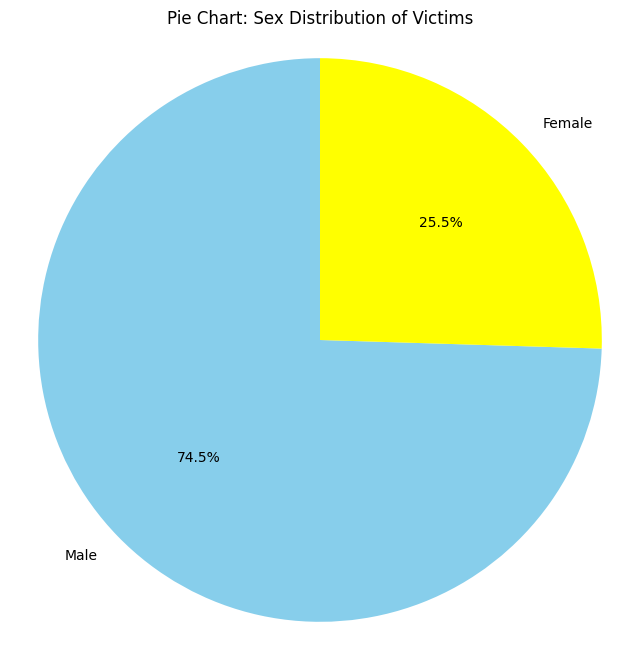

In [11]:
# 1. Pie Chart
gender_counts = df[df['sex'].str.lower() != 'unknown']['sex'].value_counts().head(2)
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'yellow'])
plt.title("Pie Chart: Sex Distribution of Victims")
plt.axis('equal')
plt.show()

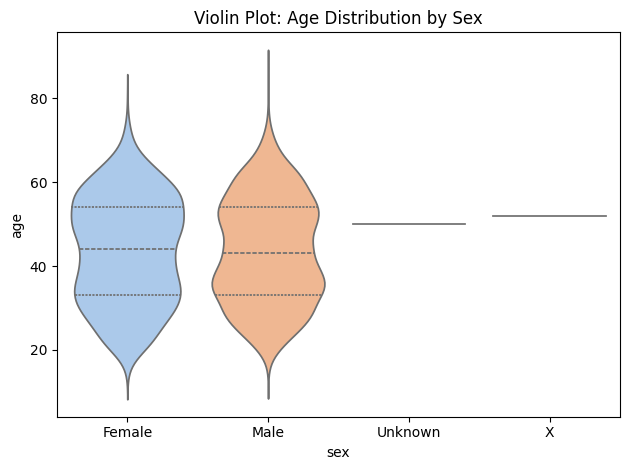

In [13]:
# 2. Violin Plot
sns.violinplot(data=df, x='sex', y='age', palette='pastel', inner='quartile')
plt.title("Violin Plot: Age Distribution by Sex")
plt.tight_layout()
plt.show()

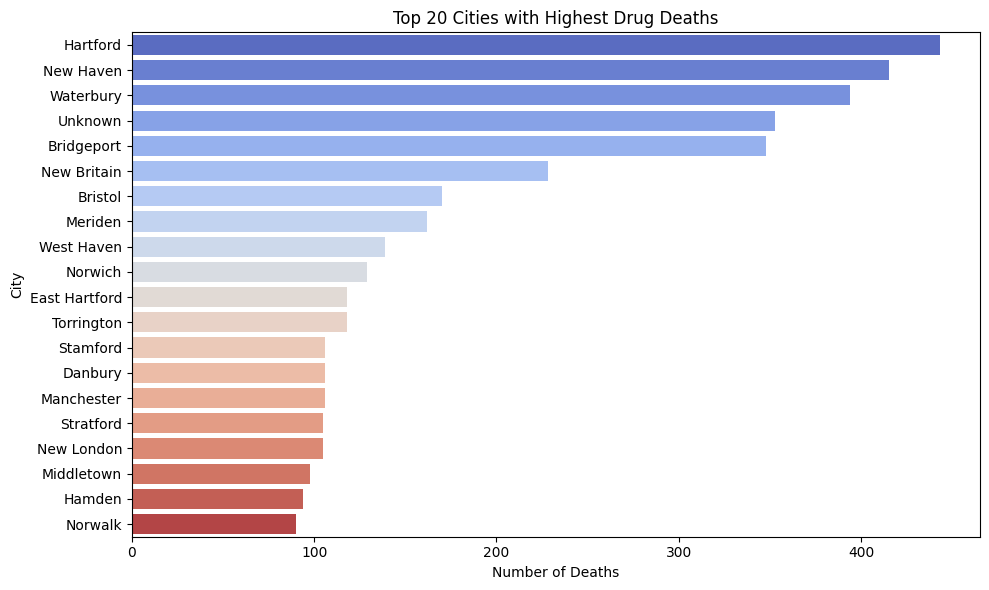

In [15]:
# 3. Bar Plot – Top 20 Cities
top_cities = df['residence_city'].value_counts().nlargest(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="coolwarm")
plt.title("Top 20 Cities with Highest Drug Deaths")
plt.xlabel("Number of Deaths")
plt.ylabel("City")
plt.tight_layout()
plt.show()

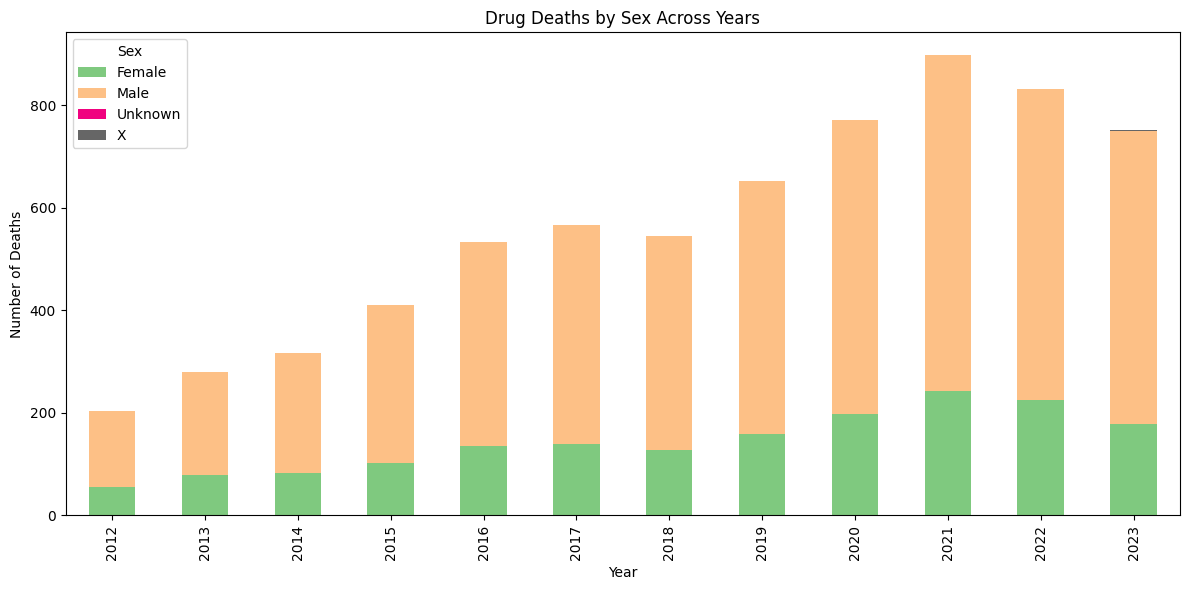

In [17]:
# 4. Stacked Bar Chart – Yearly by Sex
year_gender = df.groupby(['year', 'sex']).size().unstack().fillna(0)
year_gender.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Accent')
plt.title("Drug Deaths by Sex Across Years")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

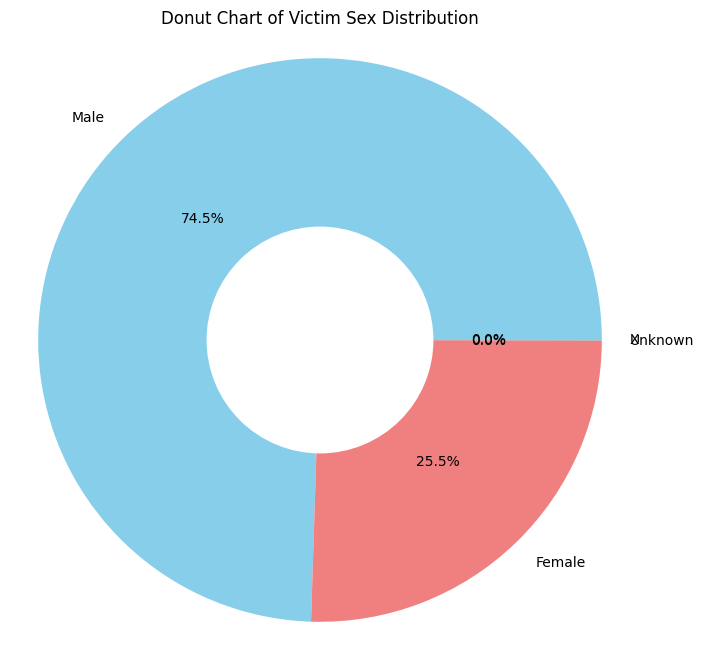

In [19]:
# 5. Donut Chart
sex_counts = df['sex'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct="%1.1f%%", colors=["skyblue", "lightcoral", "gray"])
plt.gca().add_artist(plt.Circle((0, 0), 0.4, color="white"))
plt.title("Donut Chart of Victim Sex Distribution")
plt.axis('equal')
plt.show()

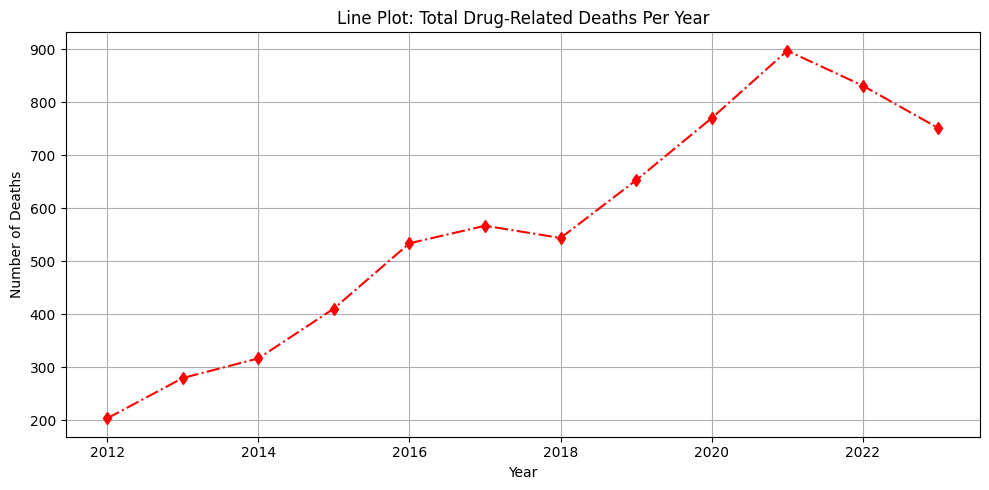

In [21]:
# 6. Line Plot – Deaths Per Year
plt.figure(figsize=(10, 5))
df_yearly = df.groupby('year').size()
plt.plot(df_yearly.index, df_yearly.values, color='red', linestyle='dashdot', marker='d')
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.title("Line Plot: Total Drug-Related Deaths Per Year")
plt.grid(True)
plt.tight_layout()
plt.show()

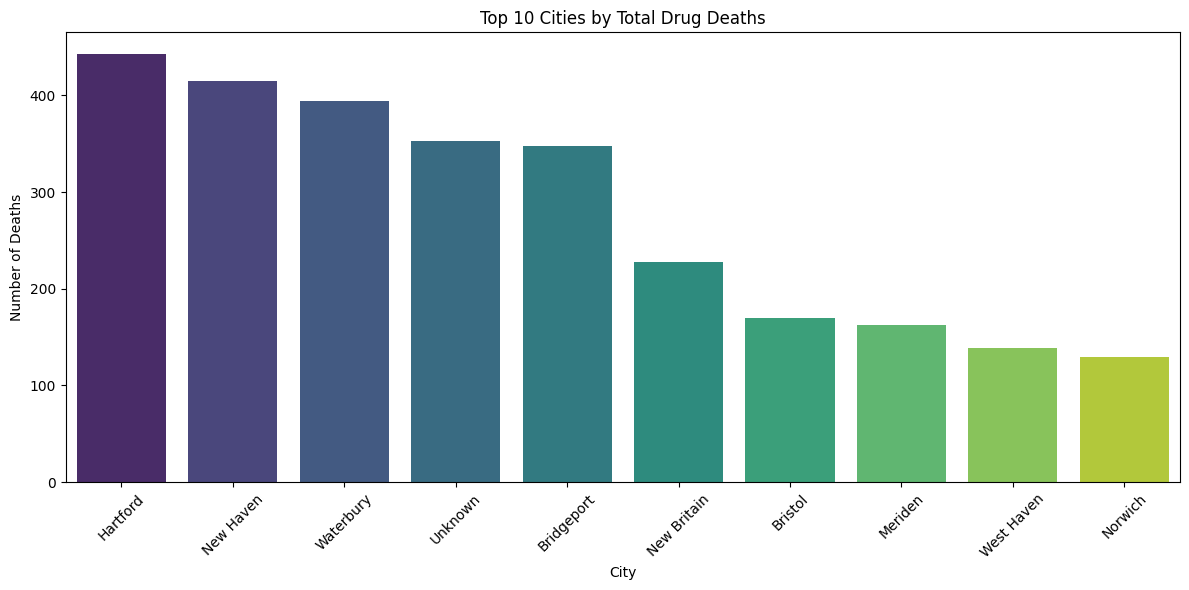

In [23]:
# 7. Bar Plot – Top 10 Cities
top_cities_10 = df['residence_city'].value_counts().nlargest(10).reset_index()
top_cities_10.columns = ['City', 'Deaths']
plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities_10, x="City", y="Deaths", hue="City", palette="viridis", legend=False)
plt.title("Top 10 Cities by Total Drug Deaths")
plt.xlabel("City")
plt.ylabel("Number of Deaths")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

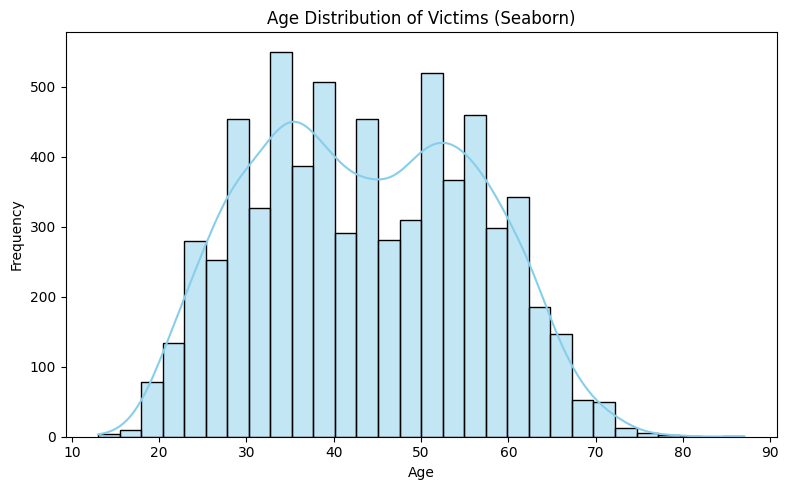

In [25]:
# 8. Histogram – Age
plt.figure(figsize=(8, 5))
sns.histplot(df['age'].dropna(), bins=30, kde=True, color="skyblue", edgecolor='black')
plt.title("Age Distribution of Victims (Seaborn)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

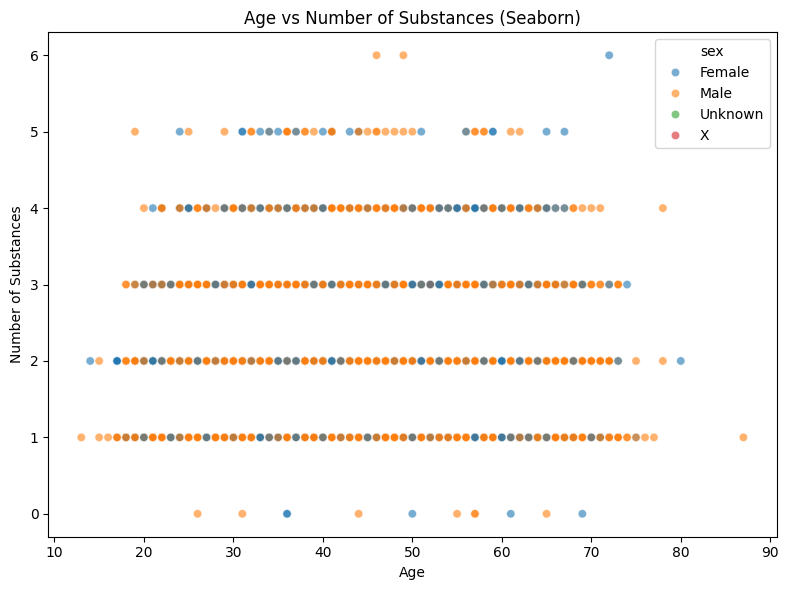

In [27]:
# 9. Scatter – Age vs Number of Substances
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["age"], y=df["number_of_substances"], hue=df["sex"], alpha=0.6)
plt.title("Age vs Number of Substances (Seaborn)")
plt.xlabel("Age")
plt.ylabel("Number of Substances")
plt.tight_layout()
plt.show()

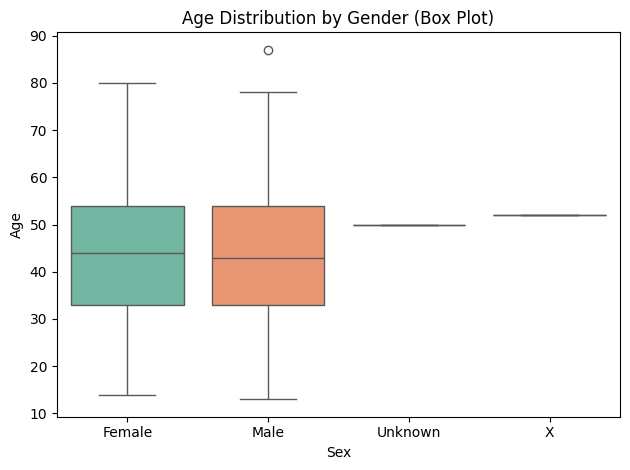

In [29]:
# 10. Box Plot – Age by Sex
sns.boxplot(x="sex", y="age", data=df, palette="Set2")
plt.title("Age Distribution by Gender (Box Plot)")
plt.xlabel("Sex")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

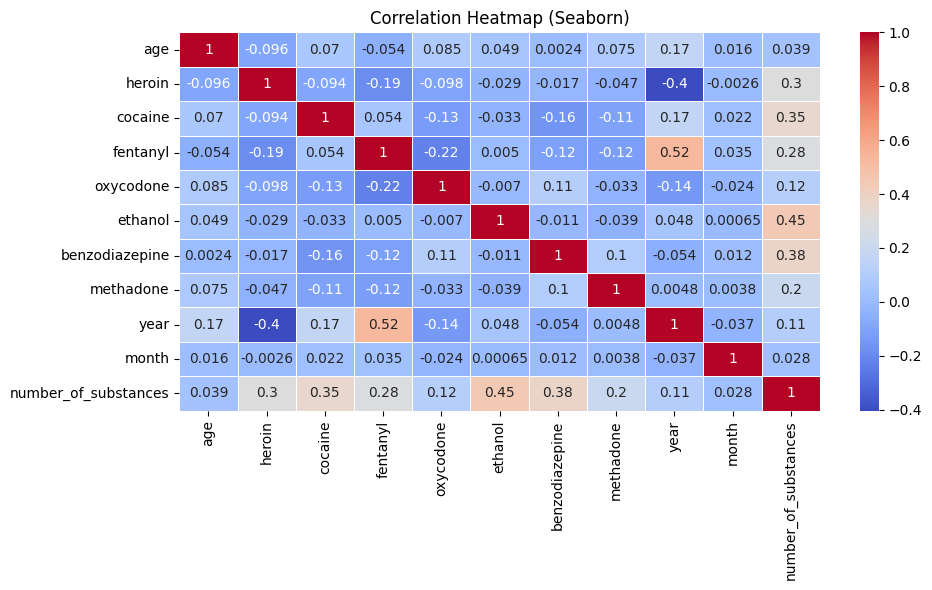

In [31]:
# 11. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, linewidths=0.5, cmap="coolwarm")
plt.title("Correlation Heatmap (Seaborn)")
plt.tight_layout()
plt.show()

In [33]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Dataset Shape:", df.shape)
print("Column Names:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

numerical = df.select_dtypes(include=[np.number])

print("\nNumerical Summary (Full):")
print(numerical.describe().T)

print("\nSkewness & Kurtosis:")
for col in numerical.columns:
    print(f"\n{col}")
    print(f"Skewness : {skew(df[col].dropna()):.2f}")
    print(f"Kurtosis : {kurtosis(df[col].dropna()):.2f}")

print("\nCentral Tendency + Spread:")
for col in numerical.columns:
    col_data = df[col].dropna()
    print(f"\n {col}")
    print(f"Mean      : {col_data.mean():.2f}")
    print(f"Median    : {col_data.median():.2f}")
    print(f"Mode      : {col_data.mode().iloc[0] if not col_data.mode().empty else 'N/A'}")
    print(f"Min       : {col_data.min()}")
    print(f"Max       : {col_data.max()}")
    print(f"Range     : {col_data.max() - col_data.min()}")
    print(f"Std Dev   : {col_data.std():.2f}")


categorical = df.select_dtypes(include=['object'])

print("\nCategorical Summary:")
for col in categorical.columns:
    print(f"\n {col}")
    print(f"Unique Values : {df[col].nunique()}")
    print(f"Top Value     : {df[col].mode()[0] if not df[col].mode().empty else 'N/A'}")
    print(f"Top Frequency : {df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 'N/A'}")


missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\nMissing Value Report (Top):")
if not missing.empty:
    print(missing.head(20))
else:
    print("No missing values found!")

print("\nCorrelation Matrix:\n")
print(numerical.corr().round(2))


Dataset Shape: (6759, 52)
Column Names:
 ['date', 'date_type', 'age', 'sex', 'race', 'ethnicity', 'residence_city', 'residence_county', 'residence_state', 'injury_city', 'injury_county', 'injury_state', 'injury_place', 'description_of_injury', 'death_city', 'death_county', 'death_state', 'location', 'location_if_other', 'cause_of_death', 'manner_of_death', 'other_significant_conditions', 'heroin', 'heroin_death_certificate_(dc)', 'cocaine', 'fentanyl', 'fentanyl_analogue', 'oxycodone', 'oxymorphone', 'ethanol', 'hydrocodone', 'benzodiazepine', 'methadone', 'meth/amphetamine', 'amphet', 'tramad', 'hydromorphone', 'morphine_(not_heroin)', 'xylazine', 'gabapentin', 'opiate_nos', 'heroin/morph/codeine', 'other_opioid', 'any_opioid', 'other', 'residencecitygeo', 'injurycitygeo', 'deathcitygeo', 'year', 'month', 'day_of_week', 'number_of_substances']

Data Types:
 date                             datetime64[ns]
date_type                                object
age                              

In [35]:
print("\n Outlier Detection using IQR Method:")

numerical = df.select_dtypes(include=[np.number])

for col in numerical.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"\n {col}")
    print(f"IQR Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Outliers Detected: {outliers.shape[0]}")



 Outlier Detection using IQR Method:

 age
IQR Range: [1.50, 85.50]
Outliers Detected: 1

 heroin
IQR Range: [-1.50, 2.50]
Outliers Detected: 0

 cocaine
IQR Range: [-1.50, 2.50]
Outliers Detected: 0

 fentanyl
IQR Range: [-1.50, 2.50]
Outliers Detected: 0

 oxycodone
IQR Range: [0.00, 0.00]
Outliers Detected: 605

 ethanol
IQR Range: [-1.50, 2.50]
Outliers Detected: 0

 benzodiazepine
IQR Range: [0.00, 0.00]
Outliers Detected: 1587

 methadone
IQR Range: [0.00, 0.00]
Outliers Detected: 647

 year
IQR Range: [2008.50, 2028.50]
Outliers Detected: 0

 month
IQR Range: [-5.00, 19.00]
Outliers Detected: 0

 number_of_substances
IQR Range: [-2.00, 6.00]
Outliers Detected: 0


In [37]:

male_ages = df[df['sex'] == 'Male']['age'].dropna()
female_ages = df[df['sex'] == 'Female']['age'].dropna()

z_stat, p_value = ztest(male_ages, female_ages)
print("\n Z-Test: Male vs Female Age")
print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {p_value:.4f}")





t_stat, p_value = ttest_1samp(df['age'].dropna(), 40)
print("\n One-sample T-Test: Age ≠ 40?")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")




t_stat, p_value = ttest_ind(male_ages, female_ages, equal_var=False)  # Welch's t-test
print("\n Two-sample T-Test: Male vs Female Age")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")




contingency = pd.crosstab(df['sex'], df['cause_of_death'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("\n Chi-Squared Test: Sex vs Cause of Death")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.4f}")



 Z-Test: Male vs Female Age
Z-statistic: -0.49
P-value: 0.6217

 One-sample T-Test: Age ≠ 40?
T-statistic: 23.22
P-value: 0.0000

 Two-sample T-Test: Male vs Female Age
T-statistic: -0.49
P-value: 0.6244

 Chi-Squared Test: Sex vs Cause of Death
Chi2 Statistic: 12953.40
Degrees of Freedom: 12744
P-value: 0.0953
